In [388]:
# Librerías
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, ElasticNetCV, LassoCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

# Análisis y decisión sobre datos faltantes.

Un 50% de nulls en una fila -> se borra ya que se considera que es un dato creado artificialmente en caso de rellenarlo por imputacion. Verificar que no se borre una gran cantidad de filas al realizar esto.

Si la variable de salida es NULL, esa fila se borrará también

Para el resto de los datos null, se realizarán imputaciones dependiendo de su distribución y tipo de variable.

- Asimetría -> mediana
- Normal -> Media
- Bimodal y Categorica -> KNN


In [389]:
#Carga de dataset
df = pd.read_csv('house-prices-tp.csv')

In [390]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


Si tenemos una observacion faltante en la variable respuesta, no sirve, asi que la podemos sacar antes de separar en train y test

In [391]:
# Analizamos los Null
df.isna().sum()

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64

In [392]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['MEDV'])
df.isna().sum()

CRIM       11
ZN         11
INDUS       4
CHAS        9
NOX         9
RM          7
AGE        11
DIS         5
RAD        12
TAX         9
PTRATIO     9
B           9
LSTAT       9
MEDV        0
dtype: int64

Hay que tener cuidado cuando decimos que solo tenemos 5% de nulls, ya que estos nulls pueden estar distribuidos de distintas maneras segun la fila, y puede terminar siendo mucho mas
Por eso hay que ver la cantidad total de filas que tienen null, y ver cuántas se quitan con nuestro Drop NA.

Para la imputacion, está bien considerar las variables categoricas, cuanto más detallados seamos y cuanto menos generalicemos a la hora de imputar, mejor
Se puede usari mputacion KNN para categoricas.

In [393]:
con_null = df.shape[0]
con_null

535

In [394]:
# Nos quedamos solo con aquellas rows con al menos 7 variables no Null
df = df.dropna(thresh=7)
df.isna().sum()

CRIM        8
ZN         10
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         3
RAD        11
TAX         8
PTRATIO     7
B           7
LSTAT       7
MEDV        0
dtype: int64

In [395]:
df['CRIM'].iloc[66]

0.19186

In [396]:
sin_null = df.shape[0]
print(f'Cantidad de filas en el dataset al comienzo: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}')
# 3%

Cantidad de filas en el dataset al comienzo: 535
Cantidad de filas en el dataset luego de quitar nulls: 532
Filas perdidas: 3
Porcentaje de filas perdidas: 0.56


In [397]:
df['CHAS'] = df['CHAS'].astype('category')


In [398]:
# Division train - test - validation
x = df.drop(columns='MEDV')
y = df['MEDV']

ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Test Split
x_remaining, x_test, y_remaining, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test)

# Ajustamos
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Validation and Train Split
x_train, x_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)


#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape
#print(X_train)
#print(y_train)

((372, 13), (80, 13), (80, 13), (372, 1), (80, 1), (80, 1))

In [399]:
#x_train=pd.DataFrame(x_train,columns=df.drop(columns='MEDV').columns)
#X_test=pd.DataFrame(X_test,columns=df.drop(columns='MEDV').columns)
#y_train = pd.DataFrame(y_train,columns=['MEDV'])
#data_train=pd.concat([x_train,y_train],axis=1)
x_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
507,0.03510,95.0,2.68,0.0,0.4161,7.853,33.2,5.1180,4.0,224.0,14.7,392.78,3.81
71,0.78420,0.0,8.14,0.0,0.5380,5.990,81.7,4.2579,4.0,307.0,21.0,386.75,14.67
332,3.53501,0.0,19.58,1.0,0.8710,6.152,82.6,1.7455,5.0,403.0,14.7,88.01,15.02
502,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79
224,3.56868,0.0,18.10,0.0,0.5800,6.437,75.0,2.8965,24.0,666.0,20.2,393.37,14.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
328,0.02875,28.0,15.04,0.0,0.4640,6.211,28.9,3.6659,4.0,270.0,18.2,396.33,6.21
495,0.10469,40.0,6.41,1.0,0.4470,7.267,49.0,4.7872,4.0,254.0,17.6,389.25,6.05
342,4.54192,0.0,18.10,0.0,0.7700,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79


In [400]:
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,524.000000,522.000000,531.000000,525.000000,527.000000,523.000000,529.000000,521.000000,524.000000,525.000000,525.000000,525.000000,532.000000
mean,4.986916,12.379853,11.226209,0.558437,6.277408,67.769735,3.887920,9.609005,409.637836,18.422824,351.069549,12.959729,22.754873
std,11.942453,24.247117,6.924961,0.118669,0.754108,28.473788,2.201751,8.676717,167.953113,2.197179,96.805981,7.517236,9.484397
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.083545,0.000000,5.130000,0.453000,5.876500,42.350000,2.106900,4.000000,279.000000,17.000000,371.720000,7.120000,16.775000
50%,0.290250,0.000000,9.690000,0.538000,6.202000,76.500000,3.317500,5.000000,334.000000,19.000000,390.950000,11.450000,21.300000
75%,4.545407,20.000000,18.100000,0.631000,6.630500,93.900000,5.287300,24.000000,666.000000,20.200000,396.060000,17.160000,26.250000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [401]:
print(df.describe(include='all'))

              CRIM          ZN       INDUS   CHAS         NOX          RM  \
count   524.000000  522.000000  531.000000  525.0  525.000000  527.000000   
unique         NaN         NaN         NaN    2.0         NaN         NaN   
top            NaN         NaN         NaN    0.0         NaN         NaN   
freq           NaN         NaN         NaN  480.0         NaN         NaN   
mean      4.986916   12.379853   11.226209    NaN    0.558437    6.277408   
std      11.942453   24.247117    6.924961    NaN    0.118669    0.754108   
min       0.006320    0.000000    0.460000    NaN    0.385000    3.561000   
25%       0.083545    0.000000    5.130000    NaN    0.453000    5.876500   
50%       0.290250    0.000000    9.690000    NaN    0.538000    6.202000   
75%       4.545407   20.000000   18.100000    NaN    0.631000    6.630500   
max      88.976200  100.000000   27.740000    NaN    0.871000    8.780000   

               AGE         DIS         RAD         TAX     PTRATIO  \
count

CRIM
count    524.000000
mean       4.986916
std       11.942453
min        0.006320
25%        0.083545
50%        0.290250
75%        4.545407
max       88.976200
Name: CRIM, dtype: float64 



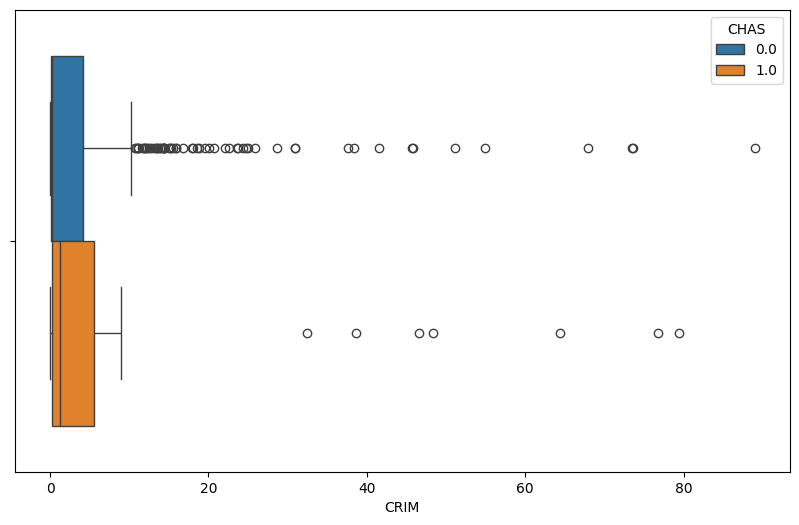

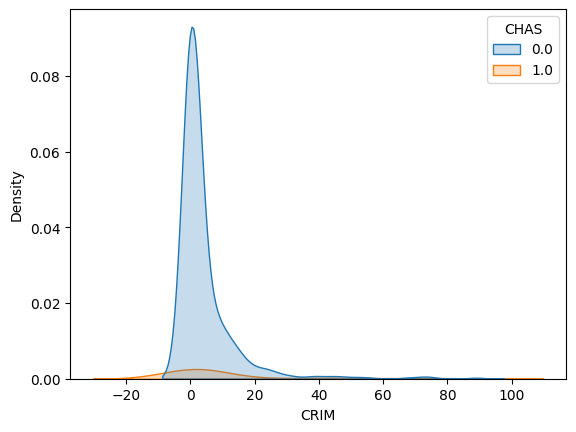

ZN
count    522.000000
mean      12.379853
std       24.247117
min        0.000000
25%        0.000000
50%        0.000000
75%       20.000000
max      100.000000
Name: ZN, dtype: float64 



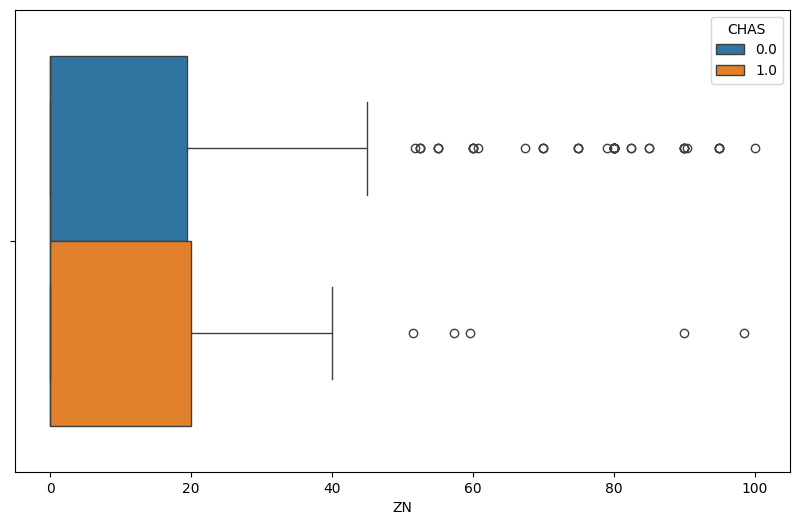

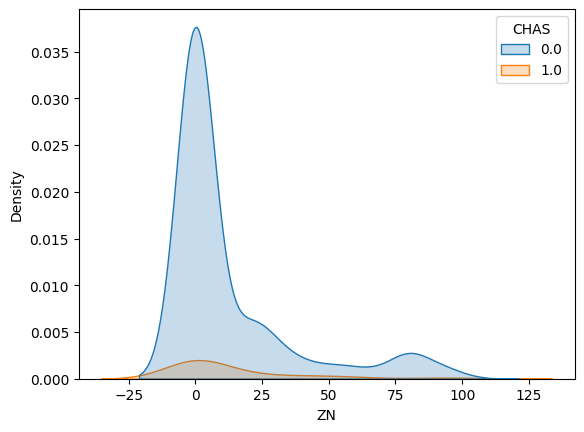

INDUS
count    531.000000
mean      11.226209
std        6.924961
min        0.460000
25%        5.130000
50%        9.690000
75%       18.100000
max       27.740000
Name: INDUS, dtype: float64 



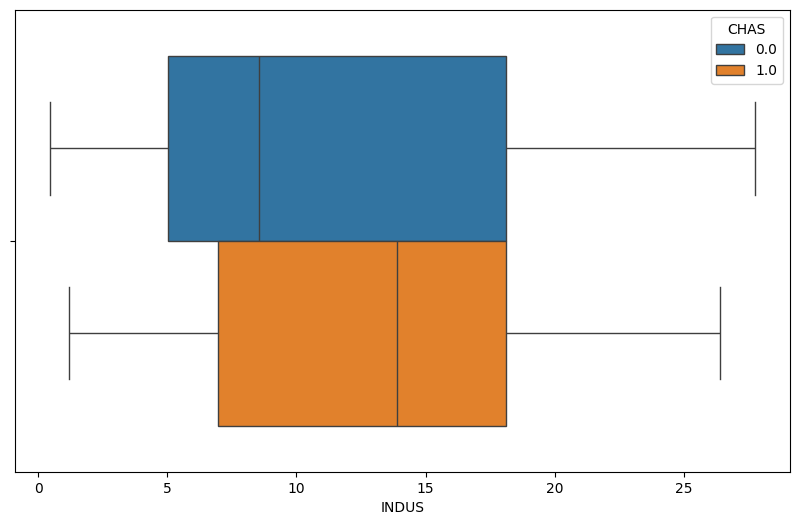

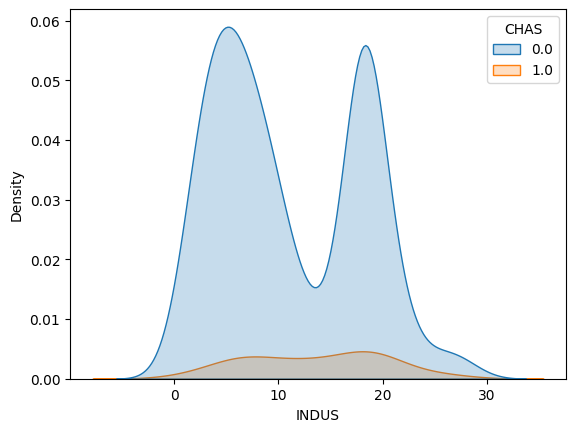

NOX
count    525.000000
mean       0.558437
std        0.118669
min        0.385000
25%        0.453000
50%        0.538000
75%        0.631000
max        0.871000
Name: NOX, dtype: float64 



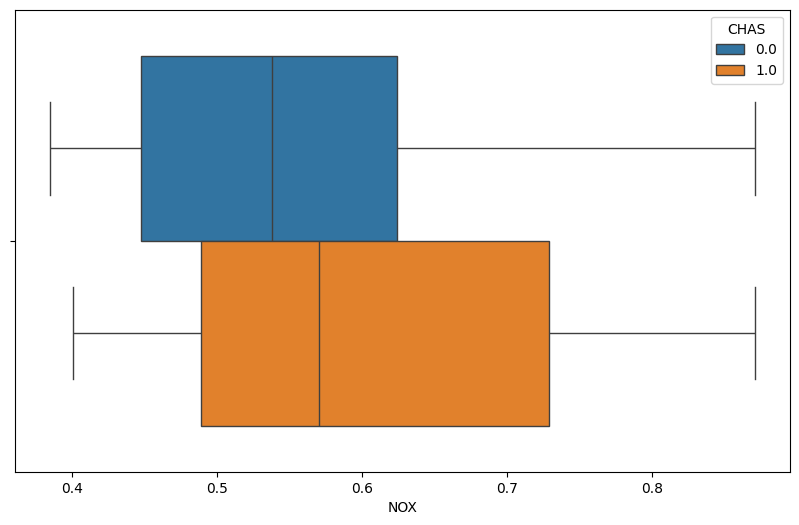

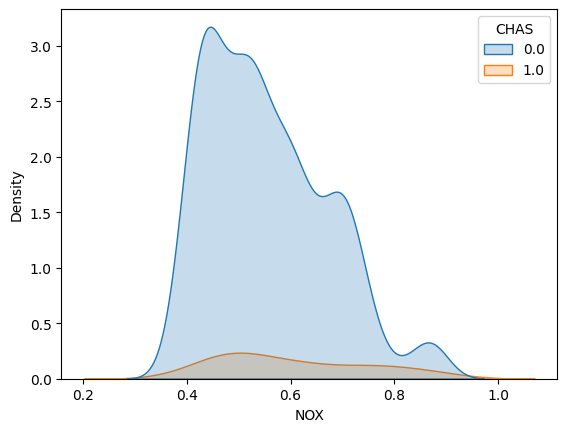

RM
count    527.000000
mean       6.277408
std        0.754108
min        3.561000
25%        5.876500
50%        6.202000
75%        6.630500
max        8.780000
Name: RM, dtype: float64 



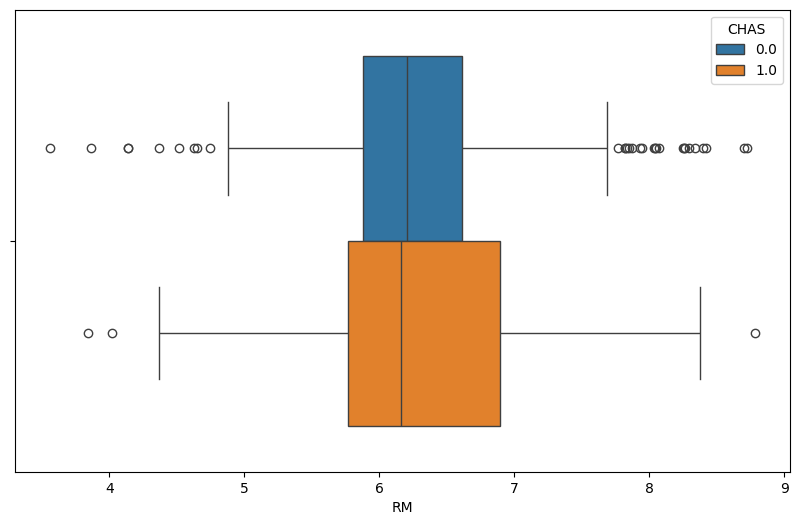

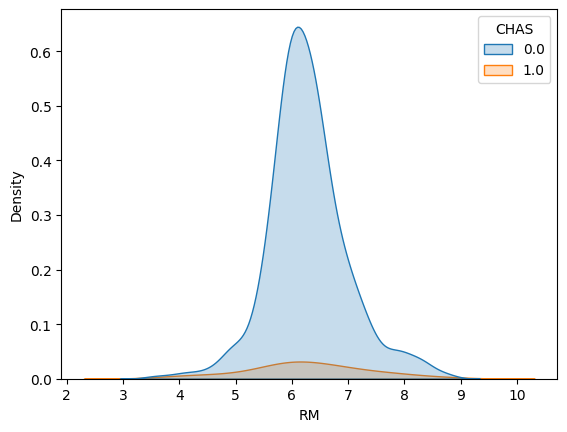

AGE
count    523.000000
mean      67.769735
std       28.473788
min        2.900000
25%       42.350000
50%       76.500000
75%       93.900000
max      100.000000
Name: AGE, dtype: float64 



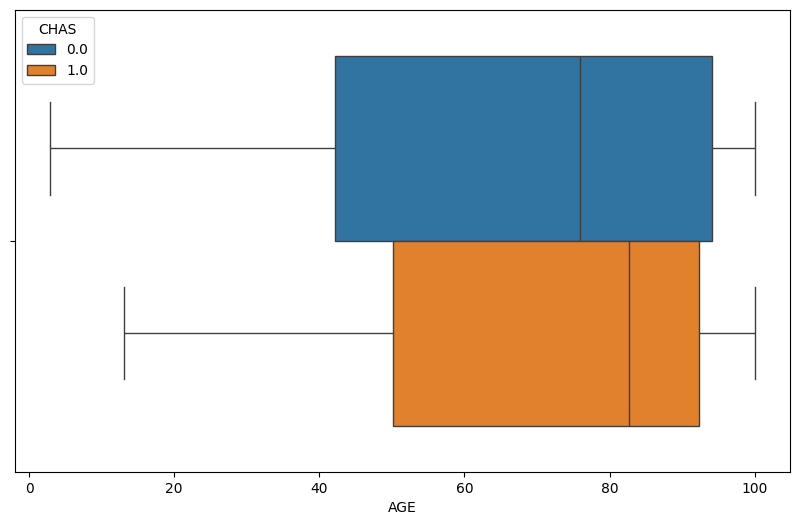

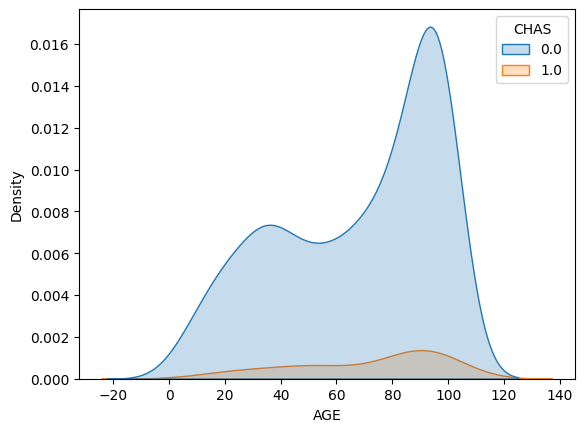

DIS
count    529.000000
mean       3.887920
std        2.201751
min        1.129600
25%        2.106900
50%        3.317500
75%        5.287300
max       12.126500
Name: DIS, dtype: float64 



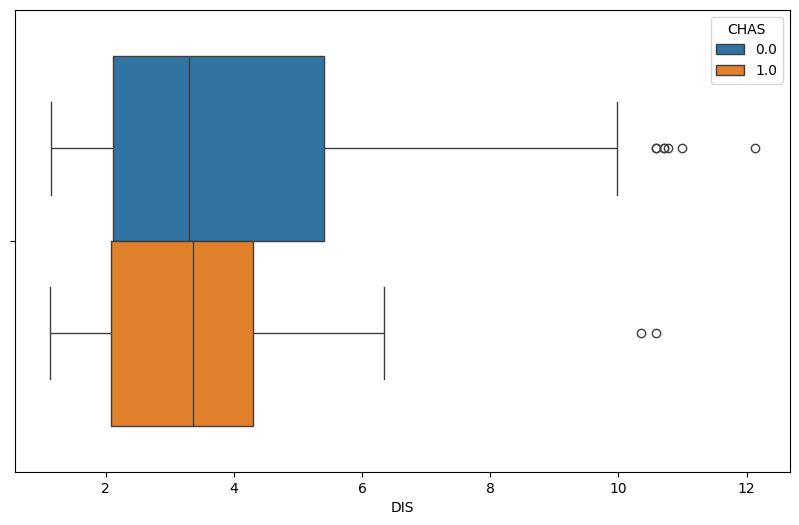

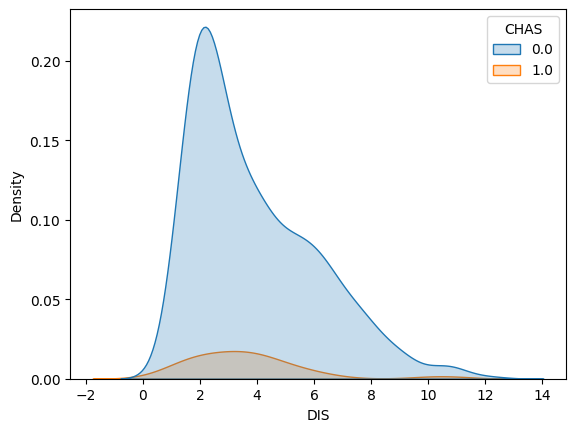

RAD
count    521.000000
mean       9.609005
std        8.676717
min        1.000000
25%        4.000000
50%        5.000000
75%       24.000000
max       24.000000
Name: RAD, dtype: float64 



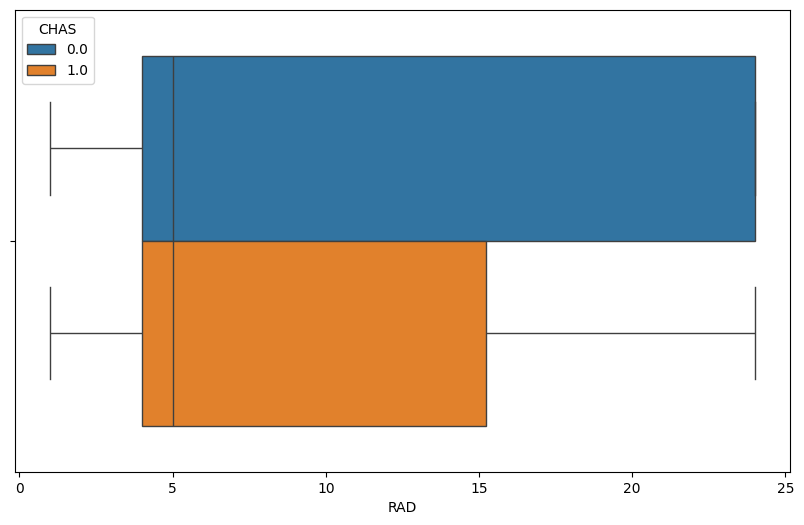

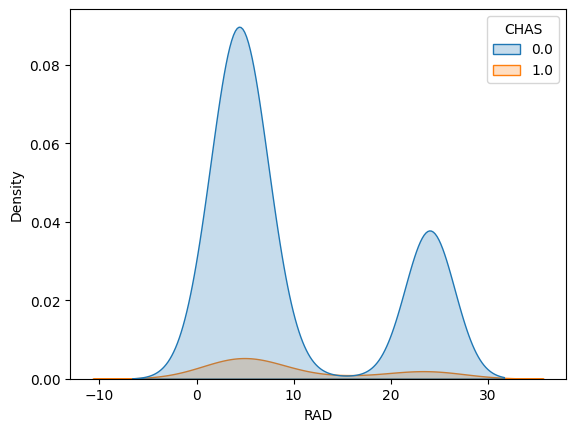

TAX
count    524.000000
mean     409.637836
std      167.953113
min      187.000000
25%      279.000000
50%      334.000000
75%      666.000000
max      711.000000
Name: TAX, dtype: float64 



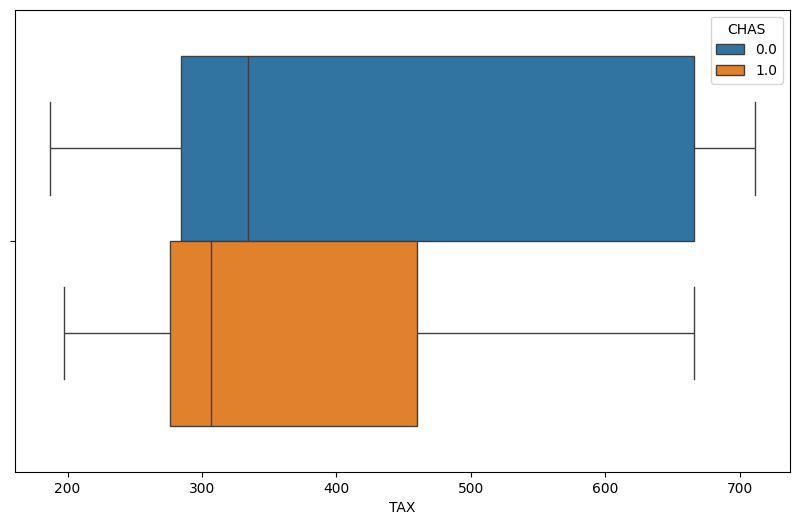

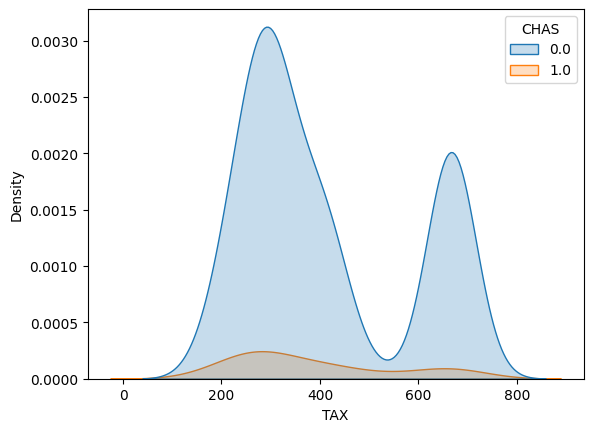

PTRATIO
count    525.000000
mean      18.422824
std        2.197179
min       12.600000
25%       17.000000
50%       19.000000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64 



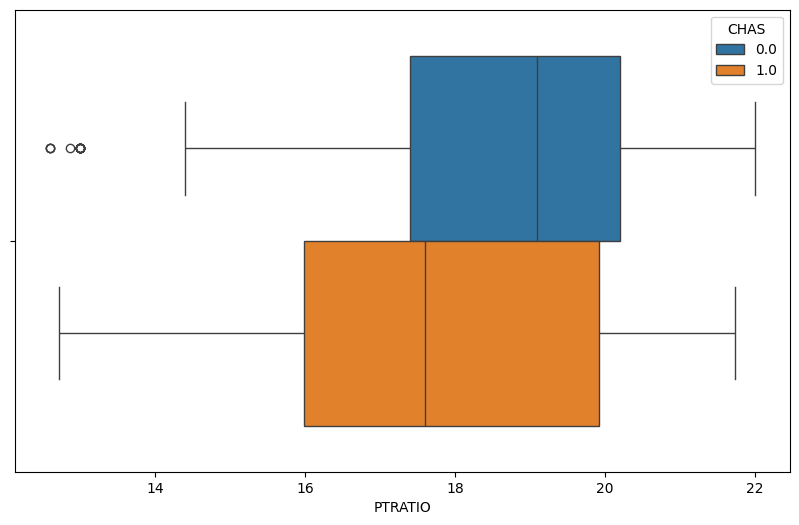

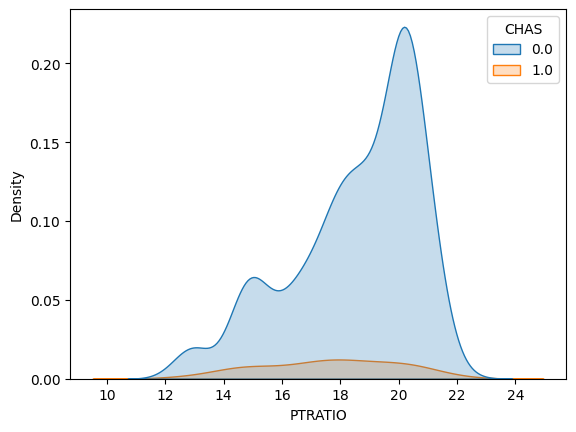

B
count    525.000000
mean     351.069549
std       96.805981
min        0.320000
25%      371.720000
50%      390.950000
75%      396.060000
max      396.900000
Name: B, dtype: float64 



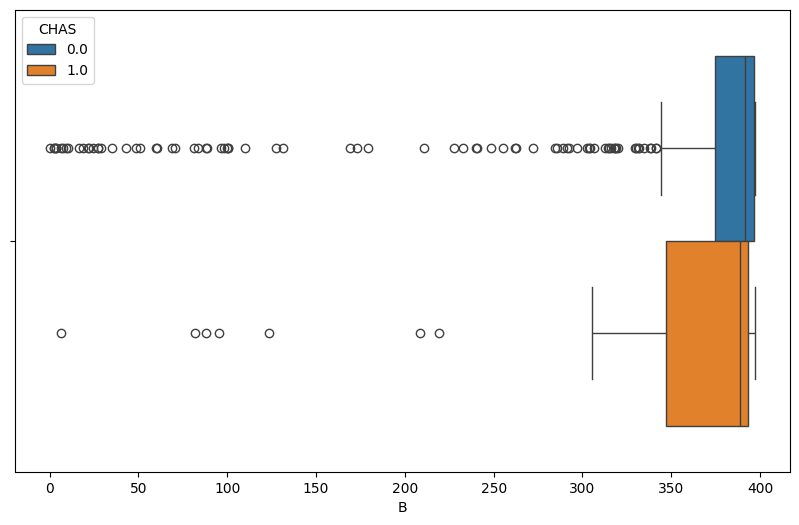

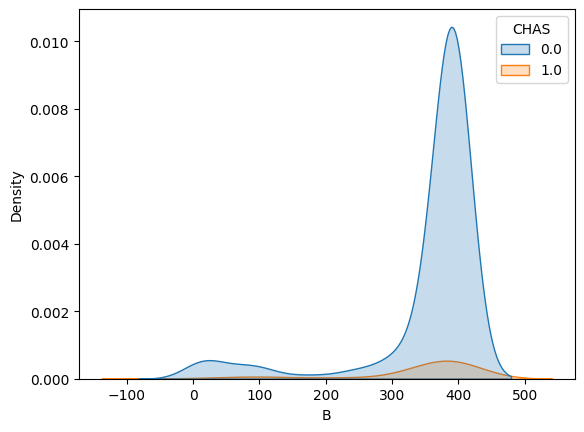

LSTAT
count    525.000000
mean      12.959729
std        7.517236
min        1.730000
25%        7.120000
50%       11.450000
75%       17.160000
max       37.970000
Name: LSTAT, dtype: float64 



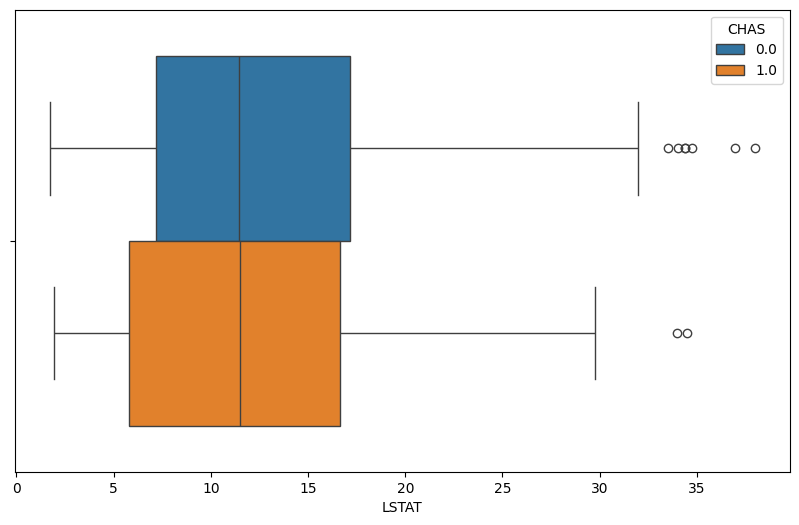

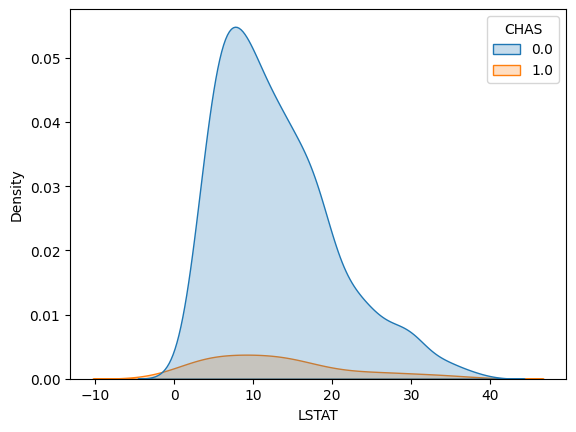

MEDV
count    532.000000
mean      22.754873
std        9.484397
min        5.000000
25%       16.775000
50%       21.300000
75%       26.250000
max       50.000000
Name: MEDV, dtype: float64 



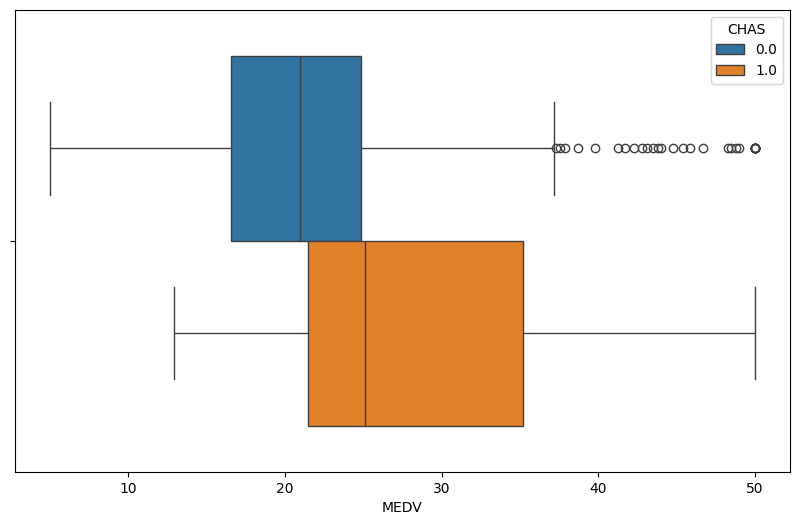

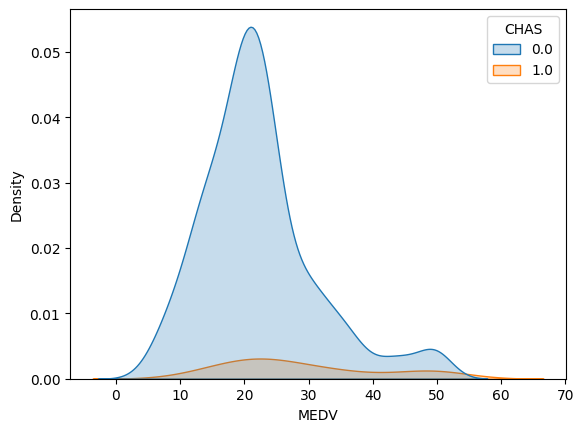

In [402]:
for columna in df:
  if not columna == 'CHAS':
    print(columna)
    print(df[columna].describe(),'\n')
    plt.figure(figsize=(10,6))
    sns.boxplot(data= df, x=columna, hue='CHAS')
    plt.show()
    #sns.kdeplot(data=df[columna],fill=True)
    sns.kdeplot(data=df,x=columna,fill=True,hue='CHAS')
    plt.show()

- CRIM: Mediana
- ZN: Mediana
- INDUS: KNN
- CHAS: KNN
- NOX: Mediana
- RM: Media
- Age: KNN
- Dis: Mediana
- Rad: KNN
- Tax: KNN
- PTRATIO: Mediana
- B: Mediana
- Lstat: Media

In [403]:
#Imputación mediante la mediana en las columnas mencionadas anteriormente
imputer_median = SimpleImputer(strategy='median')
x_train_imputer= x_train.copy()
x_val_imputer = x_val.copy()
x_test_imputer = x_test.copy()

x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.fit_transform(x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.transform(x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_val_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.transform(x_val_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       5
NOX        0
RM         3
AGE        7
DIS        0
RAD        8
TAX        4
PTRATIO    0
B          0
LSTAT      2
dtype: int64

In [404]:
#Imputación mediante la media en las columnas mencionadas anteriormente
imputer_mean = SimpleImputer(strategy='mean')
x_train_imputer[['RM', 'LSTAT']]= imputer_mean.fit_transform(x_train_imputer[['RM', 'LSTAT']])
x_val_imputer[['RM', 'LSTAT']]= imputer_mean.transform(x_val_imputer[['RM', 'LSTAT']])
x_test_imputer[['RM', 'LSTAT']]= imputer_mean.transform(x_test_imputer[['RM', 'LSTAT']])
"""
print(X_train.median())
print(X_train_imputer.loc[158])
print(X_train.loc[158])
"""
x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       5
NOX        0
RM         0
AGE        7
DIS        0
RAD        8
TAX        4
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [405]:
#Imputación mediante KNN en las columnas mencionadas anteriormente
knn_imputer = KNNImputer()
x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.fit_transform(x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
x_val_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.transform(x_val_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.transform(x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
print(x_train_imputer.isna().sum())
print(x_val_imputer.isna().sum())
print(x_test_imputer.isna().sum())


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64


In [406]:
#Escalado de Datos
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer)
x_test_scaled = scaler.transform(x_test_imputer)
x_val_scaled = scaler.transform(x_val_imputer)

#x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
#x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)
#x_val_scaled = pd.DataFrame(x_val_scaled, columns=x_val.columns)

In [407]:
#sns.pairplot(data=x_train_scaled)

In [408]:
#Escalado de datos
lr_income = LinearRegression()
lr_income.fit(x_train_scaled, y_train)

LinearRegression()

In [409]:
lr_income.intercept_

array([22.18453613])

Y = 22.92 + 0.16 x1 + 1.55 x2 + 0.23 x3

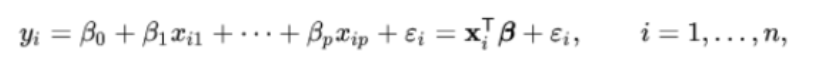

In [410]:
lr_income.coef_[0]

array([ 0.10061277,  1.79113713,  0.11135544,  1.45634564, -0.87168989,
        2.20581443, -1.26481265, -2.92958332,  1.51070593, -2.13506828,
       -1.54257774,  0.83126869, -3.12999223])

In [411]:
#R cuadrado
lr_income.score(x_train_scaled,y_train), lr_income.score(x_test_scaled,y_test), lr_income.score(x_val_scaled,y_val)

(0.634428910923615, 0.5430836923425924, 0.6244180471413426)

In [412]:
a = lr_income.coef_.tolist()[0]
a.insert(0, lr_income.intercept_.tolist()[0])
a = np.array(a)

LR = []
LR.append('Regresión lineal')
LR.append(lr_income.score(x_train_scaled,y_train))
LR.append(lr_income.score(x_val_scaled,y_val))
LR.append(lr_income.score(x_test_scaled,y_test))
LR.append(calcular_rmse(x_test_scaled, y_test, a))
LR.append(calcular_rmse(x_train_scaled, y_train, a))
comparacion = pd.DataFrame(data=[LR], columns=['Modelos', 'R2 train', 'R2 validation', 'R2 test', 'RMSE train', 'RMSE test'])

comparacion

,Modelos,R2 train,R2 validation,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.634429,0.624418,0.543084,12.716006,11.540509


In [413]:
def calcular_score(X_test, y_test, W):
    # Añadir la columna de 1's a X_test para el término de sesgo
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Predicciones del modelo
    y_pred = np.matmul(X_test_bias, W)

    # SSE: Error cuadrático residual
    SSE = np.sum((y_test - y_pred) ** 2)

    # SST: Total de errores cuadrados
    y_mean = np.mean(y_test)
    SST = np.sum((y_test - y_mean) ** 2)

    # Cálculo del score R²
    R2 = 1 - (SSE / SST)

    return R2

In [414]:
def calcular_rmse(X_test, y_test, W):
    # Añadir la columna de 1's a X_test para el término de sesgo (bias)
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    
    # Hacer las predicciones usando los pesos del modelo
    y_pred = np.matmul(X_test_bias, W)
    
    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((y_test - y_pred) ** 2)
    
    # Calcular la raíz cuadrada del MSE para obtener el RMSE
    rmse = np.sqrt(mse)
    
    return rmse

### Gradiente Estocástico

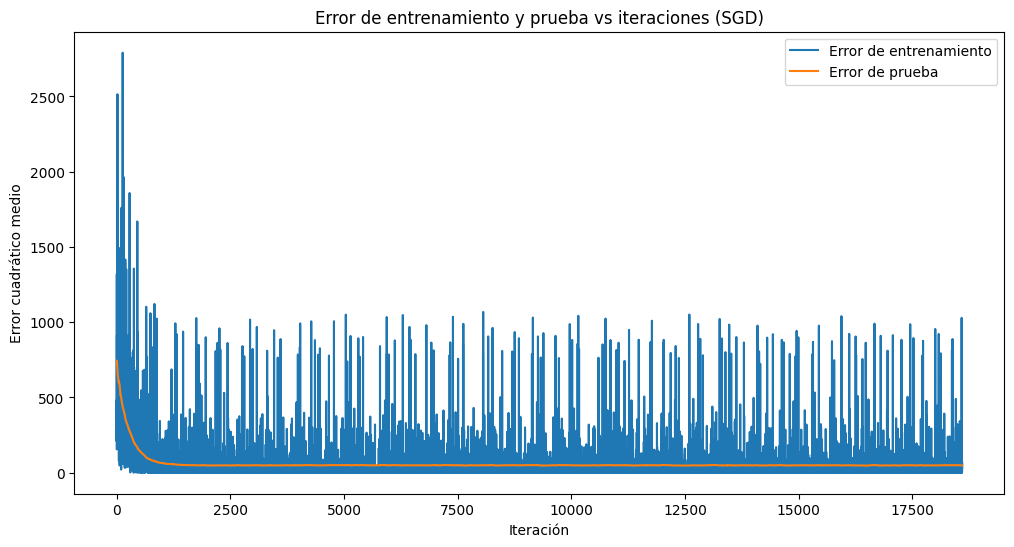

In [415]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1) # se inicializan los pesos

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation] # se reordenan los datos en base a los indices de la permutación
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W


W_SGD = stochastic_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, lr=0.001, epochs=50)

Tiene mucho ruido

In [416]:
# Llamada a la función
score1 = calcular_score(x_train_scaled,y_train, W_SGD)
score2 = calcular_score(x_test_scaled, y_test, W_SGD)
score3 = calcular_score(x_val_scaled,y_val, W_SGD)

print(score1, score2, score3)

0.6341681821492253 0.5434147212473821 0.6313358983969561


In [417]:
rmse1 = calcular_rmse(x_train_scaled, y_train, W_SGD)
rmse2 = calcular_rmse(x_test_scaled, y_test, W_SGD)

print(rmse1, rmse2)

5.459874833831187 6.967201084777736


In [418]:
GH = []
GH.append('Gradiente Estocástico')
GH.append(score1)
GH.append(score3)
GH.append(score2)
GH.append(rmse1)
GH.append(rmse2)

### Gradiente descendiente

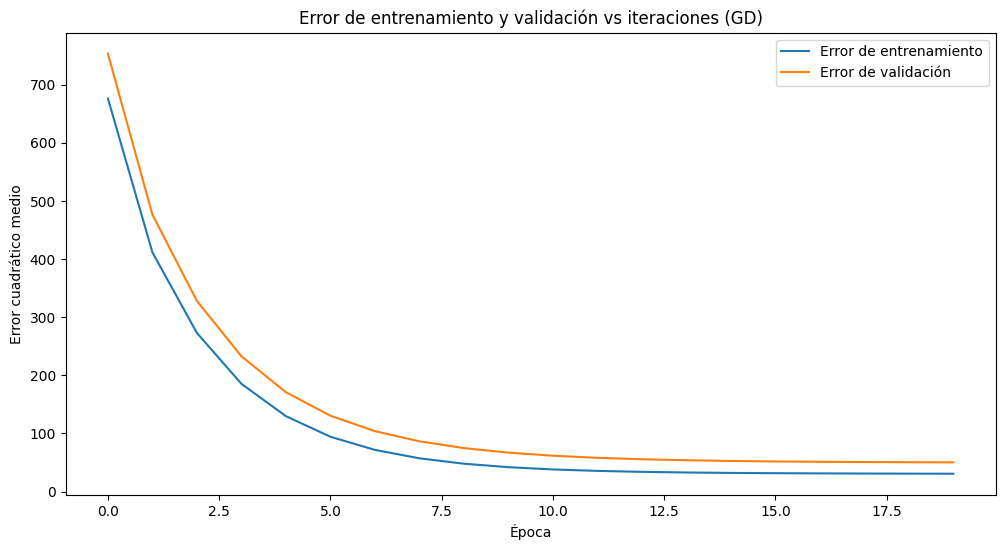

array([[ 2.19164398e+01],
       [ 8.85467671e-03],
       [ 1.68991166e+00],
       [-9.93445487e-01],
       [ 1.55072564e+00],
       [ 3.45936862e-02],
       [ 2.10643814e+00],
       [-8.80632545e-01],
       [-2.42545718e+00],
       [ 4.91584478e-01],
       [-9.01268619e-01],
       [-1.30940020e+00],
       [ 8.31816541e-01],
       [-3.35377457e+00]])

In [419]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W
x_train_scaled.shape, y_train.shape, x_val_scaled.shape, y_val.shape
 #((372, 13), (372, 1), (80, 13), (80, 1))
W_GD = gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=20)
W_GD

In [420]:
# Llamada a la función
score1 = calcular_score(x_train_scaled,y_train, W_GD)
score2 = calcular_score(x_test_scaled, y_test, W_GD)
score3 = calcular_score(x_val_scaled,y_val, W_GD)

print(score1, score2, score3)

0.624353223633632 0.5284541402118366 0.6123044492975029


In [421]:
rmse1 = calcular_rmse(x_train_scaled, y_train, W_GD)
rmse2 = calcular_rmse(x_test_scaled, y_test, W_GD)

print(rmse1, rmse2)

5.532631974552559 7.0804255532199205


In [422]:
GD = []
GD.append('Gradiente Descendiente')
GD.append(score1)
GD.append(score3)
GD.append(score2)
GD.append(rmse1)
GD.append(rmse2)

### Mini-batch Gradiente

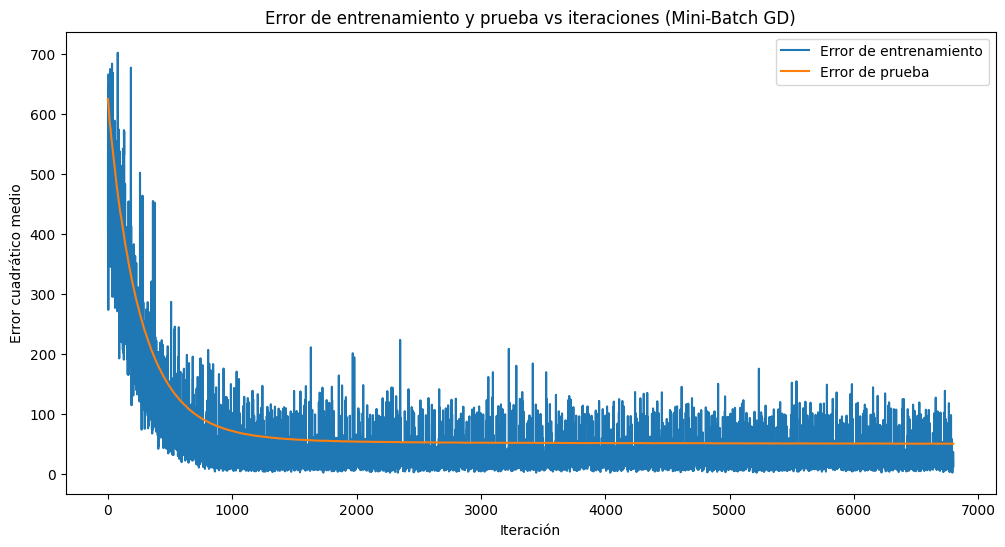

array([[22.18518788],
       [ 0.11393809],
       [ 1.76269382],
       [-0.14147672],
       [ 1.50157141],
       [-0.8093854 ],
       [ 2.13899366],
       [-1.20054863],
       [-2.93032321],
       [ 0.90978513],
       [-1.43397246],
       [-1.50066694],
       [ 0.79560391],
       [-3.26165889]])

In [423]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

W_MBG = mini_batch_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, epochs=200, lr=0.001)
W_MBG

In [424]:
score1 = calcular_score(x_train_scaled,y_train, W_MBG)
score2 = calcular_score(x_test_scaled, y_test, W_MBG)
score3 = calcular_score(x_val_scaled,y_val, W_MBG)

print(score1, score2, score3)

0.6333426589821332 0.528725788527442 0.6271516911599917


In [425]:
rmse1 = calcular_rmse(x_train_scaled, y_train, W_MBG)
rmse2 = calcular_rmse(x_test_scaled, y_test, W_MBG)

print(rmse1, rmse2)

5.466031642893054 7.078385812310979


In [426]:
GMB = []
GMB.append('Gradiente Descendiente')
GMB.append(score1)
GMB.append(score3)
GMB.append(score2)
GMB.append(rmse1)
GMB.append(rmse2)

In [427]:
data = []
data.append(GD)
data.append(GH)
data.append(GMB)

df_gradiente = pd.DataFrame(data=data, columns=['Modelos', 'R2 train', 'R2 validation', 'R2 test', 'RMSE train', 'RMSE test'])
comparacion = pd.concat([comparacion,df_gradiente],ignore_index=True)

comparacion

,Modelos,R2 train,R2 validation,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.634429,0.624418,0.543084,12.716006,11.540509
1,Gradiente Descendiente,0.624353,0.612304,0.528454,5.532632,7.080426
2,Gradiente Estocástico,0.634168,0.631336,0.543415,5.459875,6.967201
3,Gradiente Descendiente,0.633343,0.627152,0.528726,5.466032,7.078386


### LASSO

In [428]:
# Crear modelos de regresión lineal, Lasso y Ridge
lassoCV = LassoCV()  # alpha controla la fuerza de la regularización L1 (Lasso)

# Ajustar modelos a los datos
lassoCV.fit(x_train_scaled, y_train)

#Mostrar alphas
print(f'Lambda: {lassoCV.alpha_}') # lambda

print(f'LassoCV Intercept: {lassoCV.intercept_}')

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.coef_,'\n')
print(f'R2 Train: {lassoCV.score(x_train_scaled,y_train)}')
print(f'R2 Test: {lassoCV.score(x_test_scaled,y_test)}')


Lambda: 0.06712468764166162
LassoCV Intercept: 22.184536131916495

Coeficientes del modelo Lasso:
[ 0.          1.7146363  -0.          1.4299127  -0.67688012  2.16452862
 -1.13261522 -2.65188221  0.88366011 -1.5501431  -1.41568568  0.73525388
 -3.18308192] 

R2 Train: 0.6326553218308476
R2 Test: 0.5393671706842263


c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [429]:
ridgeCV = RidgeCV()  # alpha controla la fuerza de la regularización L2 (Ridge)

ridgeCV.fit(x_train_scaled, y_train)

print(f'Lambda: {ridgeCV.alpha_}')
print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.coef_,'\n')

print(f'RidgeCV Intercept: {ridgeCV.intercept_}')

print(f'R2 Train: {ridgeCV.score(x_train_scaled,y_train)}')
print(f'R2 Test: {ridgeCV.score(x_test_scaled,y_test)}')

Lambda: 10.0

Coeficientes del modelo Ridge:
[[ 0.07548686  1.69116596 -0.0093662   1.44791005 -0.79260746  2.17524989
  -1.18990858 -2.71510452  1.16700453 -1.75682706 -1.49578528  0.81066416
  -3.09266549]] 

RidgeCV Intercept: [22.18453613]
R2 Train: 0.6336865145168857
R2 Test: 0.5406848831802513


In [430]:
elasticnetCV = ElasticNetCV()
elasticnetCV.fit(x_train_scaled,y_train)
print(elasticnetCV.alpha_ )
print("\nCoeficientes del modelo ElasticNet:")

print(elasticnetCV.coef_,'\n')

print(f'ElasticNetCV Intercept: {elasticnetCV.intercept_}')

print(elasticnetCV.score(x_train_scaled,y_train))

print(f'R2 Train: {elasticnetCV.score(x_train_scaled,y_train)}')
print(f'R2 Test: {elasticnetCV.score(x_test_scaled,y_test)}')

0.1088938073065585

Coeficientes del modelo ElasticNet:
[ 0.          1.55255934 -0.0740558   1.39398772 -0.62433281  2.1342326
 -1.03938117 -2.31217177  0.60144809 -1.24415876 -1.3792684   0.73037795
 -3.05913687] 

ElasticNetCV Intercept: 22.184536131916495
0.6290452296672847
R2 Train: 0.6290452296672847
R2 Test: 0.5376095311895888


c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [431]:
W = list(lassoCV.coef_)
W.insert(0,lassoCV.intercept_)
W = np.array(W).reshape(14, 1)

print(calcular_score(x_train_scaled,y_train,W))
print(lassoCV.score(x_train_scaled,y_train))

print(calcular_rmse(x_train_scaled,y_train,W))

0.6326553218308476
0.6326553218308476
5.471152565239456


# Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)